# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [117]:
# Dependencies and Setup
import sys
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
#import time
#from scipy.stats import linregress

# Import API key
sys.path.insert(0,r'c:\Users\Owen\Desktop\DSV\_HW_Repos\python-api-challenge\common')
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [33]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
haveEnoughCities = False

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = list(zip(lats, lngs))

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
  
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

618

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [54]:
cityObjs = []
i = -1
for city in cities:
    i += 1
    try:
        print(f'processing: {i}. {city}')
        owdResult = requests.get(f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_api_key}&units=imperial')
    except:
        print('Request aborted. Request Denied')
    
    if owdResult.status_code == 200:
        print('complete')
        cityObjs.append(owdResult.json())
    else:
        print(f'Request aborted. Status Code: {owdResult.status_code}')



ing: 85. bandarbeyla
complete
processing: 86. fare
complete
processing: 87. tecolutla
complete
processing: 88. grand gaube
complete
processing: 89. prenzlau
complete
processing: 90. lazaro cardenas
complete
processing: 91. saskylakh
complete
processing: 92. ekibastuz
complete
processing: 93. marcona
Request aborted. Status Code: 404
processing: 94. vaini
complete
processing: 95. mahebourg
complete
processing: 96. hobart
complete
processing: 97. tsihombe
Request aborted. Status Code: 404
processing: 98. kodiak
complete
processing: 99. benalla
complete
processing: 100. mullaitivu
Request aborted. Status Code: 404
processing: 101. busselton
complete
processing: 102. vanimo
complete
processing: 103. killybegs
complete
processing: 104. tuktoyaktuk
complete
processing: 105. peace river
complete
processing: 106. qaanaaq
complete
processing: 107. esperance
complete
processing: 108. hilo
complete
processing: 109. nikolskoye
complete
processing: 110. rocha
complete
processing: 111. cap malheureu

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [113]:
#Write city weather data to csv
with open(output_data_file, 'w', newline = '', encoding = 'utf-8') as outFile:
    columnNames = ['City Name', 'City ID', 'Latitude', 'Longitude', 'Max Temp(F)', 'Humidity(%)', 'Wind Speed (m/s)', 'Cloudiness(%)', 'Country Code', 'Date']
    writer = csv.DictWriter(outFile, fieldnames = columnNames)
    writer.writeheader()
    for cityObj in cityObjs:
        writer.writerow({
            'City Name': cityObj['name'], 
            'City ID': cityObj['id'], 
            'Latitude': cityObj['coord']['lat'], 
            'Longitude': cityObj['coord']['lon'], 
            'Max Temp(F)': cityObj['main']['temp_max'], 
            'Humidity(%)': cityObj['main']['humidity'],
            'Wind Speed (m/s)': cityObj['wind']['speed'], 
            'Cloudiness(%)': cityObj['clouds']['all'], 
            'Country Code': cityObj['sys']['country'], 
            'Date': cityObj['dt']
            })


#Write city weather data to DataFrame
cityDataDict = {}
for cityObj in cityObjs:
    cityID = cityObj['id']
    cityName = cityObj['name']
    cityCountryCode = cityObj['sys']['country']
    cityLat = cityObj['coord']['lat']
    cityLng = cityObj['coord']['lon']
    cityMaxTemp = cityObj['main']['temp_max']
    cityHum = cityObj['main']['humidity']
    cityCloud = cityObj['clouds']['all']
    cityWindSpeed = cityObj['wind']['speed']
    cityDate = cityObj['dt']
    cityDictEntry = {
                    'city_name': cityName,
                    'lat': cityLat, 
                    'lng': cityLng,
                    'max_temp': cityMaxTemp,
                    'hum': cityHum,
                    'cloud': cityCloud,
                    'wind_speed': cityWindSpeed,
                    'country_code': cityCountryCode,
                    'date': cityDate 
                    }
    cityDataDict[cityID] = cityDictEntry
city_data = pd.DataFrame(cityDataDict).transpose()
city_data.head()


,city_name,lat,lng,max_temp,hum,cloud,wind_speed,country_code,date
3347019,Mossamedes,-15.2,12.15,69.51,77,23,9.24,AO,1603125844
3424607,Tasiilaq,65.61,-37.64,32,97,40,14.99,GL,1603125844
4030556,Rikitea,-23.12,-134.97,73.63,79,0,14.79,PF,1603125845
2206939,Bluff,-46.6,168.33,48.99,73,72,17,NZ,1603125845
6201424,Mataura,-46.19,168.86,48.99,73,66,17,NZ,1603125845


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [114]:
#retain only rows where humidity is less than or equal to 100
city_data = city_data[city_data['hum'] <= 100]


In [115]:
#  Get the indices of cities that have humidity over 100%.
humIndices = city_data[city_data['hum'] > 100].index
humIndices

Int64Index([], dtype='int64')

In [116]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = city_data[~city_data['hum'].isin(humIndices)]
clean_city_data

,city_name,lat,lng,max_temp,hum,cloud,wind_speed,country_code,date
3347019,Mossamedes,-15.2,12.15,69.51,77,23,9.24,AO,1603125844
3424607,Tasiilaq,65.61,-37.64,32,97,40,14.99,GL,1603125844
4030556,Rikitea,-23.12,-134.97,73.63,79,0,14.79,PF,1603125845
2206939,Bluff,-46.6,168.33,48.99,73,72,17,NZ,1603125845
6201424,Mataura,-46.19,168.86,48.99,73,66,17,NZ,1603125845
...,...,...,...,...,...,...,...,...,...
108410,Riyadh,24.69,46.72,80.6,18,0,5.82,SA,1603125743
1732826,Mersing,2.43,103.84,78.8,88,66,3.36,MY,1603125951
484232,Tashla,51.77,52.74,53.83,84,100,2.91,RU,1603125951
161616,Balkanabat,39.51,54.37,61.86,29,0,2.98,TM,1603125951


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

Text(0, 0.5, 'Max Temp (F)')

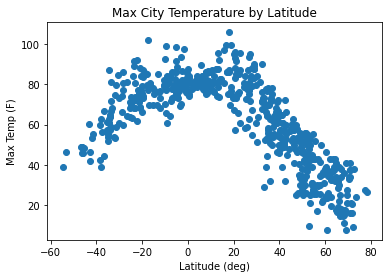

In [121]:
plt.scatter(clean_city_data['lat'].values, clean_city_data['max_temp'].values)
plt.title('Max City Temperature by Latitude')
plt.xlabel('Latitude (deg)')
plt.ylabel('Max Temp (F)')

## Latitude vs. Humidity Plot

Text(0, 0.5, 'Humidity (%)')

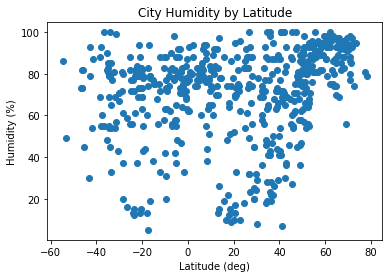

In [122]:
plt.scatter(clean_city_data['lat'].values, clean_city_data['hum'].values)
plt.title('City Humidity by Latitude')
plt.xlabel('Latitude (deg)')
plt.ylabel('Humidity (%)')

## Latitude vs. Cloudiness Plot

Text(0, 0.5, 'Cloudiness (%)')

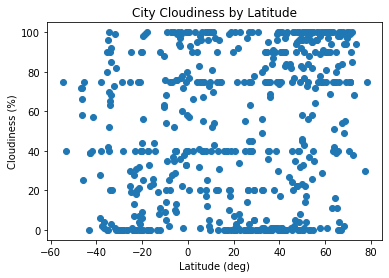

In [123]:
plt.scatter(clean_city_data['lat'].values, clean_city_data['cloud'].values)
plt.title('City Cloudiness by Latitude')
plt.xlabel('Latitude (deg)')
plt.ylabel('Cloudiness (%)')

## Latitude vs. Wind Speed Plot

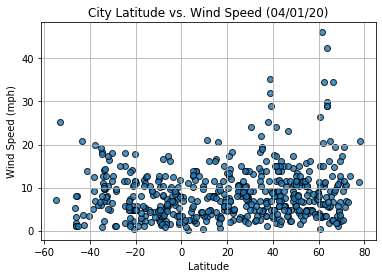

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.46937863826630627


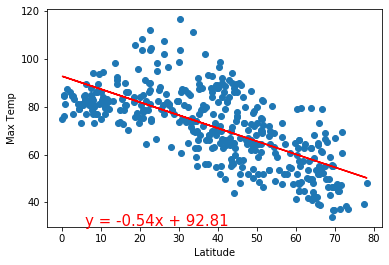

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.6082708688906918


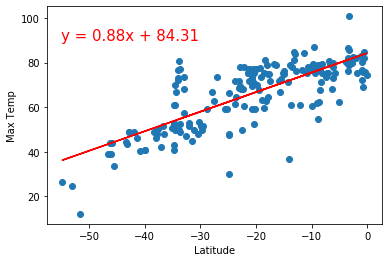

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.000543987878808455


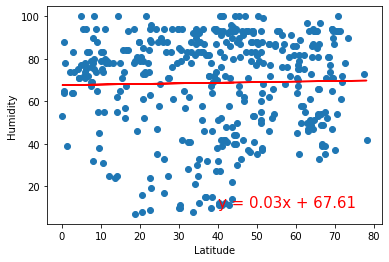

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.014985174297345524


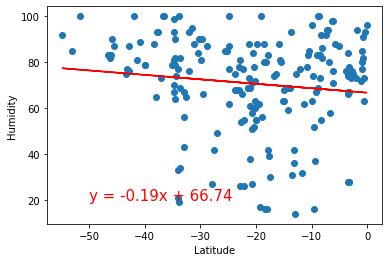

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.0020898727664228514


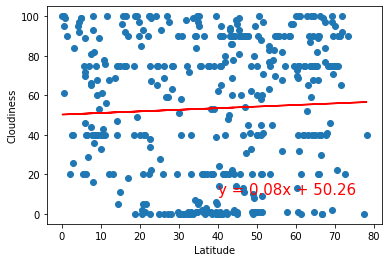

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.0035263772085582894


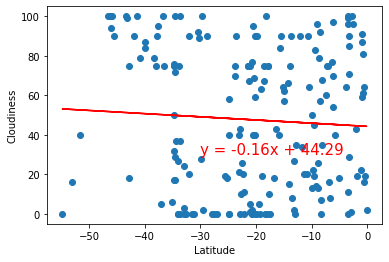

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.04019723576144484


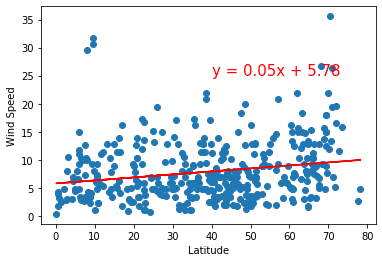

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.017128274759839232


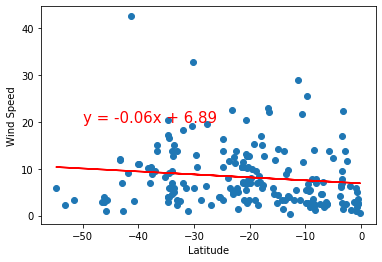